In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')
import csv
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/assignment1_colab/Telstra Case Study

/content/drive/MyDrive/assignment1_colab/Telstra Case Study


**Data files loaded from drive using pandas library**

In [4]:
train_data = pd.read_csv('train.csv',index_col='id')
test_data = pd.read_csv('test.csv',index_col='id')
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
severity_type = pd.read_csv('severity_type.csv')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7381 entries, 14121 to 17067
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   location        7381 non-null   object
 1   fault_severity  7381 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 173.0+ KB


In [6]:
train_data.head(2)

,location,fault_severity
id,,
14121,location 118,1
9320,location 91,0


In [7]:
log_feature.head(2)

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7


In [8]:
event_type.head(2)

,id,event_type
0,6597,event_type 11
1,8011,event_type 15


**1.EDA on log feature**

In [9]:
log_feature.head(3)

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1


Top 10 most occuring log_features by count

In [10]:
print(log_feature['log_feature'].value_counts()[:10])

feature 312    5267
feature 232    4754
feature 82     3472
feature 203    2823
feature 313    2145
feature 233    1901
feature 307    1597
feature 54     1573
feature 170    1526
feature 71     1514
Name: log_feature, dtype: int64


In [11]:
log_feature.dtypes

id              int64
log_feature    object
volume          int64
dtype: object

In [12]:
print('Number of distinct IDs: ', len(log_feature['id'].unique()))
print('Entries               : ', len(log_feature['id']))

Number of distinct IDs:  18552
Entries               :  58671


There are no missing data in this dataframe.

In [13]:
# No missing values
log_feature.isnull().sum()

id             0
log_feature    0
volume         0
dtype: int64

Now, let's visualize volume using distribution plot

We can clearly observe that distribution of vlume is positvely skewed

Text(0.5, 1.0, 'Volume Distribution')

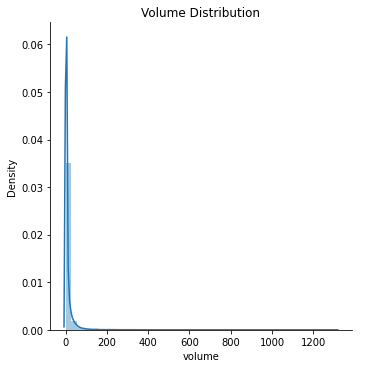

In [14]:
sns.FacetGrid(log_feature,size=5).map(sns.distplot,"volume").add_legend()
plt.title('Volume Distribution')

A box plot is also an effective method for the visual representation of statistical measures

such as the median and quartiles in univariate analysis:

**boxplot for volume**

clearly obseve that volume has outliers

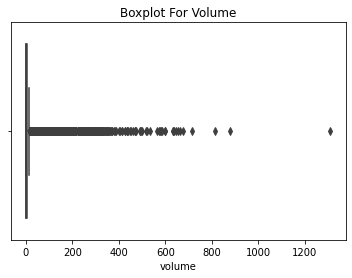

In [15]:
sns.boxplot(x="volume",data=log_feature)
plt.title('Boxplot For Volume')
plt.show()

**Merging train and test data with log_feature dataset usin merge function**

In [16]:
X = pd.merge(train_data,log_feature,how='left',left_index=True,right_index = True).fillna(0)
Y = pd.merge(test_data,log_feature, how='left',left_index=True,right_index = True).fillna(0)

New set of features have been created using the group by operation on volume feature and merged with training and test data. The new set of features created are :

1.Volume count

2.Volume minimum

3.Volume maximum

4.Volume sum

5.Volume standard deviation(std)

In [17]:
# merge log features
log_vol = log_feature.groupby('id')['volume'].agg(['count','min', 'mean', 'max', 'std', 'sum']).fillna(0).add_prefix('volume')

In [18]:
log_vol.head(2)

,volumecount,volumemin,volumemean,volumemax,volumestd,volumesum
id,,,,,,
1,3,1,1.666667,2,0.57735,5
2,5,1,1.000000,1,0.00000,5


In [19]:
X = pd.merge(X,log_vol, right_index = True,left_index=True, how='left').fillna(0)
Y = pd.merge(Y,log_vol, right_index = True,left_index=True, how='left').fillna(0)

In [20]:
print(X.shape,Y.shape)

(7381, 11) (11171, 10)


**2.EDA on resourcetype**

In [21]:
resource_type.head(3)

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8


In [22]:
resource_type.dtypes

id                int64
resource_type    object
dtype: object

In [23]:
print(resource_type['resource_type'].value_counts()[:10])

resource_type 8     10268
resource_type 2      8918
resource_type 6       582
resource_type 7       498
resource_type 4       330
resource_type 9       190
resource_type 3       145
resource_type 10       73
resource_type 1        58
resource_type 5        14
Name: resource_type, dtype: int64


In [24]:
print('Number of distinct IDs: ', len(resource_type['id'].unique()))
print('Entries               : ', len(resource_type['id']))

Number of distinct IDs:  18552
Entries               :  21076


There are no missing values.

In [25]:
# Checking for missing values
resource_type.isnull().sum()

id               0
resource_type    0
dtype: int64


Function to plt Pie Chart

In [26]:
def pie_chart(df,variable):
  labels = df[variable].value_counts().index
  values = df[variable].value_counts().values
  fig = px.pie(df, values=values, names=labels, title='Comparison of various {} based on frequency'.format(variable))
  return fig.show()

We can clearly observe that resource tpe 8 and resource type 2 ar most commonly repeating/occuring among all other resources

In [27]:
pie_chart(resource_type,'resource_type')

The resource_type feature is categorised into 10 different resources 

In [28]:
np.sort(resource_type['resource_type'].unique())

array(['resource_type 1', 'resource_type 10', 'resource_type 2',
       'resource_type 3', 'resource_type 4', 'resource_type 5',
       'resource_type 6', 'resource_type 7', 'resource_type 8',
       'resource_type 9'], dtype=object)

Merge function is used to merge data from training and test files with
resource_type data file.

In [29]:
X = pd.merge(X,resource_type, right_index = True,left_index=True, how='left').fillna(0)
Y = pd.merge(Y,resource_type, right_index = True,left_index=True, how='left').fillna(0)

In [30]:
print(X.shape,Y.shape)

(7381, 13) (11171, 12)


In [31]:
X = X.drop(['id_x','id_y'],axis= 1)
Y = Y.drop(['id_x','id_y'], axis=1)

**3.EDA on event_type**

In [32]:
event_type.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [33]:
print('Number of distinct IDs: ', len(event_type['id'].unique()))
print('Events                : ', len(event_type['id']))

Number of distinct IDs:  18552
Events                :  31170


In [34]:
# Checking for missing values
event_type.isnull().sum()

id            0
event_type    0
dtype: int64

In [35]:
X = pd.merge(X,event_type, right_index = True,left_index=True, how='left').fillna(0)
Y = pd.merge(Y,event_type, right_index = True,left_index=True, how='left').fillna(0)

In [36]:
X.head(2)

,location,fault_severity,log_feature,volume,volumecount,volumemin,volumemean,volumemax,volumestd,volumesum,resource_type,id,event_type
id,,,,,,,,,,,,,
14121,location 118,1,feature 44,2,2,19,19.0,19,0.00000,38,resource_type 2,6478,event_type 34
9320,location 91,0,feature 227,4,2,116,158.0,200,59.39697,316,resource_type 2,7252,event_type 35


● New set of features have been created using groupby operation on volume
feature at specified location and event type and merged with training and test
data. The new set of features created are :
1. Average Volume per event @Locatiion (at a location)
2. Maximum Volume per event @Location (at a location)
3. Minimum Volume per event @Location (at a location)


In [37]:
X["avgvol_per_event"]= X.groupby(['location','event_type'])["volume"].transform('mean')
X["maxvol_per_event"]= X.groupby(['location','event_type'])["volume"].transform('max')
X["minvol_per_event"]= X.groupby(['location','event_type'])["volume"].transform('mean')

Y["avgvol_per_event"]= Y.groupby(['location','event_type'])["volume"].transform('mean')
Y["maxvol_per_event"]= Y.groupby(['location','event_type'])["volume"].transform('max')
Y["minvol_per_event"]= Y.groupby(['location','event_type'])["volume"].transform('mean')

In [38]:
# merge event count
events = pd.DataFrame(event_type['id'].value_counts()).rename(columns = {'id':'events_count'})

In [39]:
X = pd.merge(X, events, right_index = True,left_index=True, how='left').fillna(0)
Y = pd.merge(Y, events, right_index = True,left_index=True, how='left').fillna(0)

**4.EDA on severity type**

In [40]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [41]:
print('Number of distinct IDs: ', len(severity_type['id'].unique()))
print('Entries               : ', len(severity_type['id']))

Number of distinct IDs:  18552
Entries               :  18552


In [42]:
# Check for missing values
severity_type.isnull().sum()

id               0
severity_type    0
dtype: int64

In [43]:
pie_chart(severity_type,'severity_type')

In [44]:
severity_type['severity_type'].unique()

array(['severity_type 2', 'severity_type 1', 'severity_type 4',
       'severity_type 5', 'severity_type 3'], dtype=object)

In [45]:
X = pd.merge(X,severity_type, right_index = True,left_index=True, how='left').fillna(0)
Y = pd.merge(Y,severity_type, right_index = True,left_index=True, how='left').fillna(0)

In [46]:
X["avgvol_per_sev"]= X.groupby(['location','severity_type'])["volume"].transform('mean')
X["maxvol_per_sev"]= X.groupby(['location','severity_type'])["volume"].transform('max')
X["minvol_per_sev"]= X.groupby(['location','severity_type'])["volume"].transform('mean')

Y["avgvol_per_sev"]= Y.groupby(['location','severity_type'])["volume"].transform('mean')
Y["maxvol_per_sev"]= Y.groupby(['location','severity_type'])["volume"].transform('max')
Y["minvol_per_sev"]= Y.groupby(['location','severity_type'])["volume"].transform('mean')

In [47]:
X.isnull().any()

location            False
fault_severity      False
log_feature         False
volume              False
volumecount         False
volumemin           False
volumemean          False
volumemax           False
volumestd           False
volumesum           False
resource_type       False
id_x                False
event_type          False
avgvol_per_event    False
maxvol_per_event    False
minvol_per_event    False
events_count        False
id_y                False
severity_type       False
avgvol_per_sev      False
maxvol_per_sev      False
minvol_per_sev      False
dtype: bool

In [48]:
print(X.shape,Y.shape)

(7381, 22) (11171, 21)


**Trasforming location feature to no of times location occured**

In [49]:
#Location Count Train:
location_count = X['location'].value_counts()
X['location_count'] = X['location'].apply(lambda x: location_count[x])

#Location Count Test:
location_count = Y['location'].value_counts()
Y['location_count'] = Y['location'].apply(lambda x: location_count[x])

In [50]:
# Python log transform
X.insert(len(X.columns), 'log_volume',np.log(X['volume']))
Y.insert(len(Y.columns), 'log_volume',np.log(Y['volume']))

In [51]:
X.head(2)

,location,fault_severity,log_feature,volume,volumecount,volumemin,volumemean,volumemax,volumestd,volumesum,resource_type,id_x,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,id_y,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count,log_volume
id,,,,,,,,,,,,,,,,,,,,,,,,
14121,location 118,1,feature 44,2,2,19,19.0,19,0.00000,38,resource_type 2,6478,event_type 34,13.333333,56,13.333333,2,17133,severity_type 1,7.250000,56,7.250000,33,0.693147
9320,location 91,0,feature 227,4,2,116,158.0,200,59.39697,316,resource_type 2,7252,event_type 35,3.090909,13,3.090909,2,213,severity_type 2,4.269231,25,4.269231,49,1.386294


In [52]:
X = X.drop(['id_x','id_y'],axis= 1)
Y = Y.drop(['id_x','id_y'], axis=1)

In [53]:
print(X.shape,Y.shape)

(7381, 22) (11171, 21)


Lets visualize this analysis in graph which shows distribution plot of values in 'volume' column and try to observe skewness and kurtosis value of 'volume' feature

We can observe very large values of both skewness and kurtosis, meaning that volume feature is High Positively Skewed and with large kurtosis value

Skewness: 11.950076
Kurtosis: 223.337118


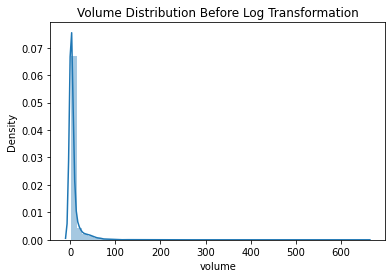

In [54]:
sns.distplot(X['volume'])
plt.title('Volume Distribution Before Log Transformation')
#skewness and kurtosis
print("Skewness: %f" % X['volume'].skew())
print("Kurtosis: %f" % X['volume'].kurt())

" We can observe that the distribution of volume shows a high positive skewness to the left (skew > 1). A kurtosis value of 223 is extremely high, meaning that there is a profusion of outliers in the dataset

As we can observe extreme data values (High kurtosis) values in 'Volume' feature, we can convert it into log scale

After converting to log scale, both skewness and kurtosis value of 'volume' feature have decreased to large extent and have converted our 'volume' feature to normal distribution

Skewness: 1.025093
Kurtosis: 0.388009


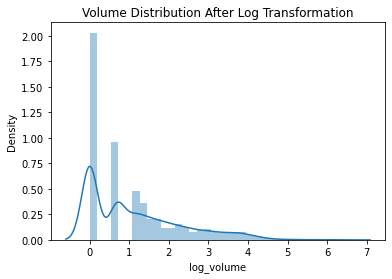

In [55]:
# Python log transform
sns.distplot(X['log_volume'])
plt.title('Volume Distribution After Log Transformation')
#skewness and kurtosis
print("Skewness: %f" % X['log_volume'].skew())
print("Kurtosis: %f" % X['log_volume'].kurt())

In [56]:
X.groupby('severity_type').volume.agg(['max', 'min', 'count', 'median', 'mean'])

,max,min,count,median,mean
severity_type,,,,,
severity_type 1,476,1,3453,2.0,7.449175
severity_type 2,451,1,3506,2.0,8.343982
severity_type 3,5,2,2,3.5,3.500000
severity_type 4,653,1,396,3.0,12.911616
severity_type 5,17,1,24,1.0,2.833333


**Multivariate Analysis on Severity type and Volume of Traffic**

In [57]:
def boxplot_cat_groupby(variable, volume_range=(0,20), size=(8,4)):
    ''' 
    Boxplot of priceUSD by data categorical variables
    '''
    results = X[[variable, 'volume']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(X['volume'].loc[X[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(volume_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('volume')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

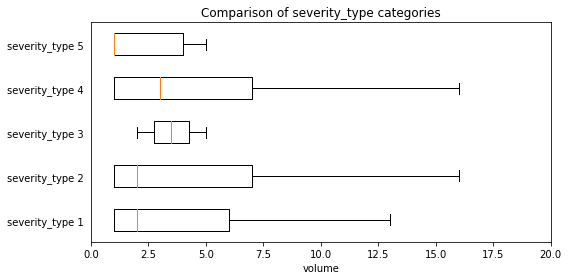

In [58]:
boxplot_cat_groupby('severity_type')

**Multivariate Analysis on Fault Severity and Volume of Traffic**

Text(0.5, 1.0, 'Volume of Traffic Based on Various Fault Severity')

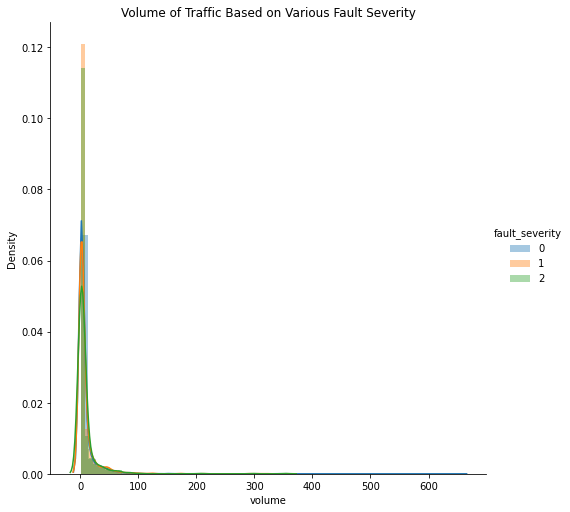

In [59]:
sns.FacetGrid(X,hue='fault_severity',size=7).map(sns.distplot,'volume').add_legend()
plt.title('Volume of Traffic Based on Various Fault Severity')

**Preparing Training and Test Data**

In [60]:
X_train = X.drop(['fault_severity'], axis=1)
X_train.head(2)

,location,log_feature,volume,volumecount,volumemin,volumemean,volumemax,volumestd,volumesum,resource_type,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count,log_volume
id,,,,,,,,,,,,,,,,,,,,,
14121,location 118,feature 44,2,2,19,19.0,19,0.00000,38,resource_type 2,event_type 34,13.333333,56,13.333333,2,severity_type 1,7.250000,56,7.250000,33,0.693147
9320,location 91,feature 227,4,2,116,158.0,200,59.39697,316,resource_type 2,event_type 35,3.090909,13,3.090909,2,severity_type 2,4.269231,25,4.269231,49,1.386294


In [61]:
y_train = X['fault_severity']

In [62]:
y_train

id
14121    1
9320     0
14394    1
8218     1
14804    0
        ..
870      0
18068    0
14111    2
15189    0
17067    0
Name: fault_severity, Length: 7381, dtype: int64

In [63]:
X_test = Y

In [64]:
X_test.head(2)

,location,log_feature,volume,volumecount,volumemin,volumemean,volumemax,volumestd,volumesum,resource_type,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count,log_volume
id,,,,,,,,,,,,,,,,,,,,,
11066,location 481,feature 312,6,4,20,24.5,28,3.415650,98,resource_type 2,event_type 34,3.500000,6,3.500000,2,severity_type 1,7.916667,66,7.916667,19,1.791759
18000,location 962,feature 232,3,2,9,14.5,20,7.778175,29,resource_type 2,event_type 11,9.368421,36,9.368421,2,severity_type 2,8.211538,74,8.211538,86,1.098612


In [65]:
print(X_train.shape,y_train.shape,X_test.shape)

(7381, 21) (7381,) (11171, 21)


**OneHot Encoder**

In [66]:
X_train.dtypes

location             object
log_feature          object
volume                int64
volumecount           int64
volumemin             int64
volumemean          float64
volumemax             int64
volumestd           float64
volumesum             int64
resource_type        object
event_type           object
avgvol_per_event    float64
maxvol_per_event      int64
minvol_per_event    float64
events_count          int64
severity_type        object
avgvol_per_sev      float64
maxvol_per_sev        int64
minvol_per_sev      float64
location_count        int64
log_volume          float64
dtype: object

**get the names of the numeric and categorical columns**

In [67]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

In [68]:
numeric_features

Index(['volume', 'volumecount', 'volumemin', 'volumemean', 'volumemax',
       'volumestd', 'volumesum', 'avgvol_per_event', 'maxvol_per_event',
       'minvol_per_event', 'events_count', 'avgvol_per_sev', 'maxvol_per_sev',
       'minvol_per_sev', 'location_count', 'log_volume'],
      dtype='object')

In [69]:
# import the needed libraries first
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# create a transformer for the categorical values
categorical_transformer1 = Pipeline(steps=[
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))])

# create a transformed for the numerical values
numeric_transformer1 = Pipeline(steps=[
    ('scaler',StandardScaler())])

In [70]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer1, numeric_features),
        ('cat', categorical_transformer1, categorical_features)
    ])

In [71]:
#index = X_train['id']

In [72]:
"""
index = X_test['id']

X_test_transformed = preprocessor.transform(X_test)

X_test = pd.DataFrame(X_test_transformed.toarray())
X_test.head(2)

X_test['id'] = index
X_train.head(2)

# shift column 'Name' to first position
first_column = X_test.pop('id')
  
# insert column using insert(position,column_name,first_column) function
X_test.insert(0, 'id', first_column)

"""

"\nindex = X_test['id']\n\nX_test_transformed = preprocessor.transform(X_test)\n\nX_test = pd.DataFrame(X_test_transformed.toarray())\nX_test.head(2)\n\nX_test['id'] = index\nX_train.head(2)\n\n# shift column 'Name' to first position\nfirst_column = X_test.pop('id')\n  \n# insert column using insert(position,column_name,first_column) function\nX_test.insert(0, 'id', first_column)\n\n"

In [73]:
X_train.head(2) 

,location,log_feature,volume,volumecount,volumemin,volumemean,volumemax,volumestd,volumesum,resource_type,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count,log_volume
id,,,,,,,,,,,,,,,,,,,,,
14121,location 118,feature 44,2,2,19,19.0,19,0.00000,38,resource_type 2,event_type 34,13.333333,56,13.333333,2,severity_type 1,7.250000,56,7.250000,33,0.693147
9320,location 91,feature 227,4,2,116,158.0,200,59.39697,316,resource_type 2,event_type 35,3.090909,13,3.090909,2,severity_type 2,4.269231,25,4.269231,49,1.386294


In [74]:
X_test.head(2)

,location,log_feature,volume,volumecount,volumemin,volumemean,volumemax,volumestd,volumesum,resource_type,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count,log_volume
id,,,,,,,,,,,,,,,,,,,,,
11066,location 481,feature 312,6,4,20,24.5,28,3.415650,98,resource_type 2,event_type 34,3.500000,6,3.500000,2,severity_type 1,7.916667,66,7.916667,19,1.791759
18000,location 962,feature 232,3,2,9,14.5,20,7.778175,29,resource_type 2,event_type 11,9.368421,36,9.368421,2,severity_type 2,8.211538,74,8.211538,86,1.098612


In [75]:
#We are then ready to transform!
X_train_transformed = preprocessor.fit_transform(X_train)

In [76]:
X_test_transformed = preprocessor.transform(X_test)

In [77]:
X_train_transformed

<7381x1173 sparse matrix of type '<class 'numpy.float64'>'
	with 155001 stored elements in Compressed Sparse Row format>

In [78]:
X_test_transformed

<11171x1173 sparse matrix of type '<class 'numpy.float64'>'
	with 234141 stored elements in Compressed Sparse Row format>

In [79]:
X_train = pd.DataFrame(X_train_transformed.toarray())
X_test = pd.DataFrame(X_test_transformed.toarray())

In [80]:
X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172
0,-0.276020,-0.548183,0.966162,0.474954,0.112209,-0.322125,0.078302,0.409893,0.568863,0.409893,0.428389,-0.074609,0.352138,-0.074609,0.401067,-0.357254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.186275,-0.548183,7.522474,6.977831,5.006183,3.469425,3.600757,-0.400255,-0.310488,-0.400255,0.428389,-0.321385,-0.235138,-0.321385,1.163754,0.220836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**Appling PCA**

In [72]:
from sklearn.decomposition import PCA
pcamodel = PCA(0.80)
pca = pcamodel.fit_transform(X_train)
pca.shape

(7381, 10)

In [80]:
pca

array([[ 4.46613810e-01,  4.19017116e-01,  3.20718210e-01, ...,
        -5.42592698e-02,  2.83843357e-01,  3.64457168e-02],
       [ 1.74326543e+00,  1.11252159e+01,  3.62751907e+00, ...,
         5.46631835e-01,  3.87786366e-01,  4.53704960e-01],
       [-1.80415152e+00, -5.37969777e-01,  1.77031314e-01, ...,
         6.62559348e-02,  5.90042347e-01, -3.55995596e-01],
       ...,
       [-2.72025219e-01,  3.95363948e-01,  7.00127993e-01, ...,
         4.40714645e-02, -1.29739700e-01,  1.32761356e-01],
       [-6.63174416e-01,  2.02448644e-01,  2.15972947e-01, ...,
         7.86269271e-02, -8.16339306e-01, -4.61643631e-02],
       [-5.72261435e-01, -7.47588045e-01,  6.06897893e-01, ...,
         4.50524824e-01, -5.21278615e-01,  6.35689216e-03]])

Explained variance is the amount of variance explained by each of the selected components. This attribute is associated with the sklearn PCA model as explained_variance_

In [73]:
pcamodel.explained_variance_ 

array([4.52125324, 3.98336276, 1.63259226, 1.33683131, 1.22093261,
       0.92619567, 0.9173837 , 0.60878191, 0.44023373, 0.38763743])


Explained variance ratio is the percentage of variance explained by each of the selected components. It’s attribute is explained_variance_ratio_

In [74]:
pcamodel.explained_variance_ratio_

array([0.22786897, 0.20075955, 0.08228186, 0.06737565, 0.06153441,
       0.04667981, 0.04623569, 0.03068231, 0.02218757, 0.01953674])

 After performing encoding, the total size of training data turned out to be
(7381,1173).

● In order to reduce the number of features from 1173, PCA has been performed
such that it captures 80% of variance from all the features.

● After performing PCA, the dimensionality of data reduced from (7381,1173) to
(7381,10).

The x-axis displays the principal component and the y-axis displays the percentage of total variance explained by each individual principal component

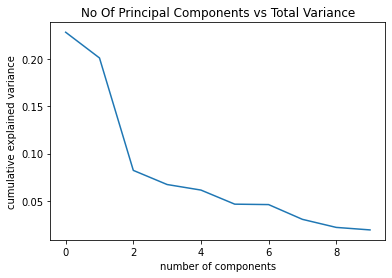

In [83]:
plt.plot(pcamodel.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('No Of Principal Components vs Total Variance')
plt.show()

The first principal component(PCA1) explains 22.01% of the total variation in the dataset followed by PCA2 with 20.02%, PCA3 with 8.22%, PCA4 with 6.73%, PCA5 with 6.15%, PCA6 with 4.66%, PCA7 with 4.62%, PCA8 with 3.06%, PCA9 with 2.2% and PCA10 with 2%.

**Scatter plot of PCA1 and PCA2**

pca helds all PCA components. First two of them can be visualized using scatter plot.

Text(0.5, 1.0, 'Scatter plot of PCA1 and PCA2')

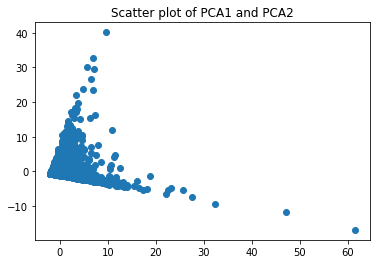

In [84]:
plt.scatter(pca[:, 0], pca[:, 1])
plt.title('Scatter plot of PCA1 and PCA2')

In [59]:
X_test.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172
0,-0.096530,0.342155,1.033753,0.732262,0.355556,-0.104090,0.838544,-0.367897,-0.453638,-0.367897,0.428389,-0.019417,0.541582,-0.019417,-0.266284,0.558997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.231148,-0.548183,0.290253,0.264429,0.139248,0.174388,-0.035734,0.096279,0.159863,0.096279,0.428389,0.004995,0.693137,0.004995,2.927467,-0.019093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [60]:
print(X_train.shape,y_train.shape,X_test.shape)

(7381, 1173) (7381,) (11171, 1173)


**PHASE -3 ANALYSIS WILLBE DONE BY IMPLEMENTING VARIOUS ALGORITHMS AND PERFORMING ERROR ANALYSIS**

In [62]:
classifiers = [KNeighborsClassifier(),
               RandomForestClassifier(),
               GaussianNB(),
               LogisticRegression(multi_class='multinomial', solver='lbfgs'),

              ]
classifier_names = ['kNN','forest','GNB','LogReg']

In [55]:
# Loop through classifiers
for classifier, clf_name in zip(classifiers, classifier_names):
  # Calculate CV
  print(clf_name,'\t',cross_val_score(estimator=classifier,X=X_train, y=y_train, cv=5, scoring='f1_macro').mean())

kNN 	 0.43795969120056766
forest 	 0.45696832590720726
GNB 	 0.4275236998965579
LogReg 	 0.5074252804649324


In [63]:
lgregr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lgregr.fit(X_train,y_train)  # Fit classifier on training set
y_pred = lgregr.predict(X_test) # Predict fault severity on test set

In [ ]:
"""
# predict a multinomial probability distribution
yhat = lgregr.predict_proba(X_test.values)
"""

In [ ]:
"""
from sklearn.metrics import log_loss

loss2tr = log_loss(y_train.values, lgregr.predict_proba(X_train.values))
loss2te = log_loss(y_.values, clf.predict_proba(Xte))
print("Random Forest: train loss {:.4f}, test loss {:.4f}".format(loss2tr, loss2te))

"""

In [ ]:
"""
from sklearn.metrics import log_loss

loss2tr = log_loss(y_train.values, lgregr.predict_proba(X_train.values))
print("Logistic Regression: train loss {:.4f}".format(loss2tr))

"""

Logistic Regression: train loss 0.5556


In [ ]:
"""
loss2te = log_loss(y_test.values, clf.predict_proba(X_test))
print("Logistic Regression: test loss {:.4f}".format(loss2te))

"""

In [ ]:
y_pred.shape

(11171,)

In [ ]:
Y_id = Y
Y_id.head(2)

,location,log_feature,volume,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,resource_type,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count
id,,,,,,,,,,,,,,,,,,,,
11066,location 481,feature 312,6,4,20,24.5,28,3.415650,98,resource_type 2,event_type 34,3.500000,6,3.500000,2,severity_type 1,7.916667,66,7.916667,19
18000,location 962,feature 232,3,2,9,14.5,20,7.778175,29,resource_type 2,event_type 11,9.368421,36,9.368421,2,severity_type 2,8.211538,74,8.211538,86


In [ ]:
Y_id = Y_id.reset_index() 

In [ ]:
Y_id.head(2)

,id,location,log_feature,volume,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,resource_type,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count
0,11066,location 481,feature 312,6,4,20,24.5,28,3.415650,98,resource_type 2,event_type 34,3.500000,6,3.500000,2,severity_type 1,7.916667,66,7.916667,19
1,18000,location 962,feature 232,3,2,9,14.5,20,7.778175,29,resource_type 2,event_type 11,9.368421,36,9.368421,2,severity_type 2,8.211538,74,8.211538,86


In [ ]:
index = Y_id['id']

In [ ]:
Y_id['id'] = index

In [ ]:
y_pred.ndim

1

In [ ]:
results = pd.get_dummies(y_pred)     # create separate columns
results.columns = ['predict_0', 'predict_1', 'predict_2']  #rename cols
#data_test = X_test.reset_index()
results = pd.concat([Y_id[['id']], results], axis=1) # merge with index
results = results.set_index('id')  # set ID as index
results.head()

,predict_0,predict_1,predict_2
id,,,
11066,1,0,0
18000,0,0,1
16964,1,0,0
4795,1,0,0
3392,1,0,0


In [ ]:
results.to_csv('sub_OHE_Minmax.csv')

In [ ]:
from src.telstra_data import TelstraData, multiclass_log_loss

ModuleNotFoundError: ignored

In [ ]:
loss2tr = multiclass_log_loss(ytr.values, clf.predict_proba(Xtr))
loss2te = multiclass_log_loss(yte.values, clf.predict_proba(Xte))
print("Random Forest: train loss {:.4f}, test loss {:.4f}".format(loss2tr, loss2te))

In [ ]:
# logistic regression for feature importance
from matplotlib import pyplot

In [ ]:
np.round(lgregr.coef_,decimals=2) > 0

array([[False, False,  True, ..., False,  True,  True],
       [ True, False, False, ...,  True, False,  True],
       [False,  True,  True, ..., False, False, False]])

In [ ]:
import numpy as np
coefs=lgregr.coef_[0]
top_three = np.argpartition(coefs, -3)[-3:]
top_three_sorted=top_three[np.argsort(coefs[top_three])]
print(coefs.feature_names[top_three_sorted])

AttributeError: ignored

In [ ]:
X_test_transformed

In [ ]:
X_test = pd.DataFrame(X_test_transformed.toarray())

In [ ]:
X_test.head(2)

In [ ]:
# shift column 'Name' to first position
first_column = X_train.pop('id')
  
# insert column using insert(position,column_name,first_column) function
X_train.insert(0, 'id', first_column)

In [ ]:
X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171
0,-0.276020,-0.548183,0.966162,0.474954,0.112209,-0.322125,0.078302,0.409893,0.568863,0.409893,0.428389,-0.074609,0.352138,-0.074609,0.401067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.186275,-0.548183,7.522474,6.977831,5.006183,3.469425,3.600757,-0.400255,-0.310488,-0.400255,0.428389,-0.321385,-0.235138,-0.321385,1.163754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_train.set_index('id',inplace = True)

AttributeError: ignored

In [ ]:
y_train

id
14121    1
9320     0
14394    1
8218     1
14804    0
        ..
870      0
18068    0
14111    2
15189    0
17067    0
Name: fault_severity, Length: 7381, dtype: int64

In [ ]:
X_test.head(2)

,location,log_feature,volume,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,resource_type,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count
id,,,,,,,,,,,,,,,,,,,,
11066,location 481,feature 312,6,4,20,24.5,28,3.415650,98,resource_type 2,event_type 34,3.500000,6,3.500000,2,severity_type 1,7.916667,66,7.916667,19
18000,location 962,feature 232,3,2,9,14.5,20,7.778175,29,resource_type 2,event_type 11,9.368421,36,9.368421,2,severity_type 2,8.211538,74,8.211538,86


In [ ]:
index = X_test['id']

X_test_transformed = preprocessor.transform(X_test)

X_test = pd.DataFrame(X_test_transformed.toarray())
X_test.head(2)

X_test['id'] = index
X_train.head(2)

# shift column 'Name' to first position
first_column = X_test.pop('id')
  
# insert column using insert(position,column_name,first_column) function
X_test.insert(0, 'id', first_column)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape)

(7381, 1172) (7381,) (11171, 20)


In [ ]:
X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171
0,-0.276020,-0.548183,0.966162,0.474954,0.112209,-0.322125,0.078302,0.409893,0.568863,0.409893,0.428389,-0.074609,0.352138,-0.074609,0.401067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.186275,-0.548183,7.522474,6.977831,5.006183,3.469425,3.600757,-0.400255,-0.310488,-0.400255,0.428389,-0.321385,-0.235138,-0.321385,1.163754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Loop through classifiers
for classifier, clf_name in zip(classifiers, classifier_names):
  # Calculate CV
  print(clf_name,'\t',cross_val_score(estimator=classifier,X=X_train, y=y_train, cv=5, scoring='f1_macro').mean())

kNN 	 0.43436519203501217
forest 	 0.4692374530295817
GNB 	 0.4275236998965579
LogReg 	 0.5081480967158335


In [ ]:
X_test.head(2)

,location,log_feature,volume,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,resource_type,event_type,avgvol_per_event,maxvol_per_event,minvol_per_event,events_count,severity_type,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,location_count
id,,,,,,,,,,,,,,,,,,,,
11066,location 481,feature 312,6,4,20,24.5,28,3.415650,98,resource_type 2,event_type 34,3.500000,6,3.500000,2,severity_type 1,7.916667,66,7.916667,19
18000,location 962,feature 232,3,2,9,14.5,20,7.778175,29,resource_type 2,event_type 11,9.368421,36,9.368421,2,severity_type 2,8.211538,74,8.211538,86
